In [43]:
#Import packages
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import datetime
from datetime import timedelta, date

%config InlineBackend.figure_format = 'png'
%matplotlib inline 

In [44]:
# Write a date.time script that iterates between two dates at a set delta (in this case delta = 7, or every Saturday
# To get the 2020 and 2021 data drom the MTA. Keep in mind the first and laste week should be a week before (-1 week).
start_date = date(2020,10,31)
end_date = date(2021,1,30)
delta = datetime.timedelta(days=7)

In [45]:
# Create the lisk of weeks
dates_mta = []

while start_date <= end_date:
    start_date += delta
    d = start_date.strftime("%y%m%d") 
    dates_mta.append(int(d)) 

# Check if my list worked 
# This is my list of weeks to be scraped from the mta website. 

print(dates_mta)

[201107, 201114, 201121, 201128, 201205, 201212, 201219, 201226, 210102, 210109, 210116, 210123, 210130, 210206]


In [46]:
# Download the data files from MTA's website http://web.mta.info/developers/turnstile.html

def get_data(dates_mta):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" 
    dfs = []
    for week_num in dates_mta:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        

turnstiles_df = get_data(dates_mta)

In [47]:
# Save the fram into a .csv
turnstiles_df.to_csv('mta_data_all.csv', header = False, index = False)

Create a database in the same folder using sqlite in Terminal (Mac). Write this:

```commandline
sqlite3 mta.db
```

In command line, you should now be in sqlite3. You should see this:

```comanndline
sqlite>
```

To add your table, use this SQL statement:

```sql
CREATE TABLE mta_data (
	CA TEXT,
	UNIT TEXT,
	SCP TEXT,
	STATION TEXT,
	LINENAME TEXT,
	DIVISION TEXT,
	DATE TEXT,
	TIME TEXT,
	DESC TEXT,
	ENTRIES INTEGER,
	EXITS INTEGER,
	PRIMARY KEY (CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS)
	);
```

Ok, so now we'll try inserting an entire file. Note that if you already inserted a single row into your table, you'll have a duplicate row.

Still in sqlite3 with in the command line, run this code:

```sql
.mode csv
.import mta_data_all.csv mta_data
```

In [48]:
# Connect your notebook to the mta.db
engine = create_engine("sqlite:///mta.db")

# Read the table mta_table
all_data = pd.read_sql('SELECT * FROM mta_data;', engine)

In [49]:
# Test the table has data
# all_data.info()

In [50]:
# Let's use SQL for the Exploratory Data Analysys (EDA)
# The total number of rows in the table
pd.read_sql('SELECT COUNT(*) FROM mta_data',engine)

,COUNT(*)
0,2942639


In [51]:
# The unique values of column "DESC"
pd.read_sql('SELECT DISTINCT DESC FROM mta_data',engine)

,DESC
0,REGULAR
1,RECOVR AUD


In [52]:
# The number of rows where the audit of counter was distructed
pd.read_sql('SELECT COUNT(*) FROM mta_data WHERE DESC == "RECOVR AUD"',engine)

,COUNT(*)
0,11162


In [53]:
# The results by ascending order
pd.read_sql('SELECT * FROM mta_data ORDER BY DATE',engine).head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,03:00:00,REGULAR,7511448,2558786
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,07:00:00,REGULAR,7511451,2558789
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,11:00:00,REGULAR,7511461,2558813
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,15:00:00,REGULAR,7511495,2558831
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,19:00:00,REGULAR,7511620,2558857


In [54]:
# The number of rows where the date is not in the investigated period (NOV - JAN)
pd.read_sql('SELECT COUNT(*) FROM mta_data WHERE DATE LIKE "10%" OR DATE LIKE "02%"', engine)

,COUNT(*)
0,180822


In [55]:
pd.read_sql('SELECT COUNT(DISTINCT TIME) FROM mta_data',engine)

,COUNT(DISTINCT TIME)
0,55803


In [56]:
#The sum entries of the stations are too high, possible issue with the ENTRIES values
pd.read_sql('SELECT STATION, SUM(ENTRIES) FROM mta_data GROUP BY STATION', engine)

,STATION,SUM(ENTRIES)
0,1 AV,275916927334
1,103 ST,79383543002
2,103 ST-CORONA,37472645330
3,104 ST,994725648708
4,110 ST,24245148515
...,...,...
373,WOODLAWN,19412440969
374,WORLD TRADE CTR,941968634938
375,WTC-CORTLANDT,433042636583
376,YORK ST,17424098719


In [57]:
# Continue the Exploratory Data Analysys (EDA) with Python pandas
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [58]:
# Remote the snnecessary spaces at the beggining and end
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [60]:
# Rename STATION Agregate 
turnstiles_df.rename(columns = {'STATION' : 'STATION_2'}, inplace = True)
turnstiles_df.head()


,C/A,UNIT,SCP,STATION_2,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,00:00:00,REGULAR,7481098,2545767
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,04:00:00,REGULAR,7481103,2545767
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,08:00:00,REGULAR,7481117,2545786
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,12:00:00,REGULAR,7481158,2545831
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,16:00:00,REGULAR,7481285,2545868


In [61]:
# Rename and and LINAME to STATION
turnstiles_df["STATION"] = turnstiles_df["STATION_2"] + " "+ turnstiles_df["LINENAME"]
turnstiles_df.head()

,C/A,UNIT,SCP,STATION_2,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,00:00:00,REGULAR,7481098,2545767,59 ST NQR456W
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,04:00:00,REGULAR,7481103,2545767,59 ST NQR456W
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,08:00:00,REGULAR,7481117,2545786,59 ST NQR456W
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,12:00:00,REGULAR,7481158,2545831,59 ST NQR456W
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,16:00:00,REGULAR,7481285,2545868,59 ST NQR456W


In [62]:
# Combine DATE and TIME into DATE_TIME

turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME,
                                 format="%m/%d/%Y %H:%M:%S")
turnstiles_df.head()

,C/A,UNIT,SCP,STATION_2,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,00:00:00,REGULAR,7481098,2545767,59 ST NQR456W,2020-10-31 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,04:00:00,REGULAR,7481103,2545767,59 ST NQR456W,2020-10-31 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,08:00:00,REGULAR,7481117,2545786,59 ST NQR456W,2020-10-31 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,12:00:00,REGULAR,7481158,2545831,59 ST NQR456W,2020-10-31 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/31/2020,16:00:00,REGULAR,7481285,2545868,59 ST NQR456W,2020-10-31 16:00:00


In [63]:
# Get rid of duplicate entries
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [64]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST NQR456W,2020-10-31 00:00:00,1
1961741,R138,R293,00-02-05,34 ST-PENN STA 123ACE,2020-11-13 21:00:00,1
1961721,R138,R293,00-02-05,34 ST-PENN STA 123ACE,2020-11-10 13:00:00,1
1961722,R138,R293,00-02-05,34 ST-PENN STA 123ACE,2020-11-10 17:00:00,1
1961723,R138,R293,00-02-05,34 ST-PENN STA 123ACE,2020-11-10 21:00:00,1


In [65]:
# The maximum ENTRIES value would occur at the last reading of the day. 
# Since rows are listed in descending order of time, we can grab the last reading of the day 
# (located at the top of the group) using the .first() DataFrame method.
turnstiles_df_daily = (turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).ENTRIES.first())
turnstiles_df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST NQR456W,01/01/2021,7511647
1,A002,R051,02-00-00,59 ST NQR456W,01/02/2021,7511996
2,A002,R051,02-00-00,59 ST NQR456W,01/03/2021,7512214
3,A002,R051,02-00-00,59 ST NQR456W,01/04/2021,7512754
4,A002,R051,02-00-00,59 ST NQR456W,01/05/2021,7513300


In [66]:
# Calculate the daily entries
turnstiles_df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .shift(1))
turnstiles_df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST NQR456W,01/01/2021,7511647,NaN,NaN
1,A002,R051,02-00-00,59 ST NQR456W,01/02/2021,7511996,01/01/2021,7511647.0
2,A002,R051,02-00-00,59 ST NQR456W,01/03/2021,7512214,01/02/2021,7511996.0
3,A002,R051,02-00-00,59 ST NQR456W,01/04/2021,7512754,01/03/2021,7512214.0
4,A002,R051,02-00-00,59 ST NQR456W,01/05/2021,7513300,01/04/2021,7512754.0


In [67]:
# Drop the rows for the earliest date in the df
turnstiles_df_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnstiles_df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST NQR456W,01/02/2021,7511996,01/01/2021,7511647.0
2,A002,R051,02-00-00,59 ST NQR456W,01/03/2021,7512214,01/02/2021,7511996.0
3,A002,R051,02-00-00,59 ST NQR456W,01/04/2021,7512754,01/03/2021,7512214.0
4,A002,R051,02-00-00,59 ST NQR456W,01/05/2021,7513300,01/04/2021,7512754.0
5,A002,R051,02-00-00,59 ST NQR456W,01/06/2021,7513790,01/05/2021,7513300.0


In [68]:
# Sanity check, verify the months. It should be only the months 11, 12, and 01
turnstiles_df_daily['MONTH'] = (turnstiles_df_daily['DATE'].str[0:2])
turnstiles_df_daily['MONTH'].value_counts()

12    154432
01    149397
11    149267
02     24945
10      4960
Name: MONTH, dtype: int64

In [69]:
# Use only the required time frame: 11, 12, and 01
mask = ((turnstiles_df_daily["MONTH"] == "11") |
        (turnstiles_df_daily["MONTH"] == "12") |
        (turnstiles_df_daily["MONTH"] == "01"))

turnstiles_df_months = turnstiles_df_daily[mask].copy()
turnstiles_df_months

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,MONTH
1,A002,R051,02-00-00,59 ST NQR456W,01/02/2021,7511996,01/01/2021,7511647.0,01
2,A002,R051,02-00-00,59 ST NQR456W,01/03/2021,7512214,01/02/2021,7511996.0,01
3,A002,R051,02-00-00,59 ST NQR456W,01/04/2021,7512754,01/03/2021,7512214.0,01
4,A002,R051,02-00-00,59 ST NQR456W,01/05/2021,7513300,01/04/2021,7512754.0,01
5,A002,R051,02-00-00,59 ST NQR456W,01/06/2021,7513790,01/05/2021,7513300.0,01
...,...,...,...,...,...,...,...,...,...
488017,TRAM2,R469,00-05-01,RIT-ROOSEVELT R,12/27/2020,5554,12/26/2020,5554.0,12
488018,TRAM2,R469,00-05-01,RIT-ROOSEVELT R,12/28/2020,5554,12/27/2020,5554.0,12
488019,TRAM2,R469,00-05-01,RIT-ROOSEVELT R,12/29/2020,5554,12/28/2020,5554.0,12
488020,TRAM2,R469,00-05-01,RIT-ROOSEVELT R,12/30/2020,5554,12/29/2020,5554.0,12


In [70]:
# Gut check. We should expect positive daily entries, and nothing drastically large: 
(turnstiles_df_months["ENTRIES"] - turnstiles_df_months["PREV_ENTRIES"]).describe()

count    4.530960e+05
mean    -4.504478e+02
std      4.579851e+06
min     -1.242137e+09
25%      4.300000e+01
50%      1.790000e+02
75%      3.860000e+02
max      1.821543e+09
dtype: float64

In [71]:
# How many rows are backwards
turnstiles_df_months[turnstiles_df_months["ENTRIES"] < turnstiles_df_months["PREV_ENTRIES"]].shape

(4092, 9)

In [72]:
# Let's see how many stations are in reverse
(turnstiles_df_months[turnstiles_df_months["ENTRIES"] < turnstiles_df_months["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION                 
A011  R080  01-03-00  57 ST-7 AV NQRW             91
            01-03-01  57 ST-7 AV NQRW              1
A014  R081  02-00-00  49 ST NQRW                   1
A025  R023  01-03-01  34 ST-HERALD SQ BDFMNQRW     1
A031  R083  00-00-01  23 ST NRW                    1
                                                  ..
R728  R226  00-03-01  GUN HILL RD 5                1
            00-03-02  GUN HILL RD 5                1
            00-03-03  GUN HILL RD 5                1
            00-05-00  GUN HILL RD 5                1
R730  R431  00-00-04  EASTCHSTER/DYRE 5           91
Length: 226, dtype: int64

In [73]:
# Handle the large entries
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_df_months["DAILY_ENTRIES"] = turnstiles_df_months.apply(get_daily_counts, axis=1, max_counter=200000)

entries: 52806 <-- 17116894.0
entries: 289 <-- 3055256.0
entries: 198 <-- 5102094.0
entries: 123 <-- 1630877.0
entries: 20 <-- 2642748.0
entries: 26 <-- 3963030.0
entries: 393278 <-- 32986.0
entries: 169 <-- 2172444.0
entries: 43 <-- 3039842.0
entries: 77 <-- 295924.0
entries: 524288 <-- 267179.0
entries: 589976 <-- 328913.0
entries: 1294 <-- 6496220.0
entries: 196 <-- 690417.0
entries: 262198 <-- 1028467.0
entries: 58 <-- 262198.0
entries: 455 <-- 2822958.0
entries: 327834 <-- 2642486.0
entries: 34 <-- 270294.0
entries: 524347 <-- 1485358.0
entries: 262182 <-- 526704.0
entries: 524338 <-- 67889725.0
entries: 544 <-- 475738131.0
entries: 262231 <-- 532342.0
entries: 16796392 <-- 123975.0
entries: 453044031 <-- 1779426.0
entries: 15 <-- 310200.0
entries: 91 <-- 4038371.0
entries: 157 <-- 3563454.0
entries: 120 <-- 3319940.0
entries: 394 <-- 2773389.0
entries: 100 <-- 2493895.0
entries: 280 <-- 7355319.0
entries: 1160 <-- 2419490.0
entries: 589826 <-- 53147.0
entries: 2293788 <-- 4259642

In [74]:
turnstiles_df_months.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,MONTH,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST NQR456W,01/02/2021,7511996,01/01/2021,7511647.0,01,349.0
2,A002,R051,02-00-00,59 ST NQR456W,01/03/2021,7512214,01/02/2021,7511996.0,01,218.0
3,A002,R051,02-00-00,59 ST NQR456W,01/04/2021,7512754,01/03/2021,7512214.0,01,540.0
4,A002,R051,02-00-00,59 ST NQR456W,01/05/2021,7513300,01/04/2021,7512754.0,01,546.0
5,A002,R051,02-00-00,59 ST NQR456W,01/06/2021,7513790,01/05/2021,7513300.0,01,490.0


In [75]:
# Check daily entries
turnstiles_df_months.DAILY_ENTRIES.describe()

count    453096.000000
mean        281.341246
std        1136.241030
min           0.000000
25%          48.000000
50%         183.000000
75%         391.000000
max      196858.000000
Name: DAILY_ENTRIES, dtype: float64

In [76]:
# Entries per month
turnstiles_df_months.MONTH.value_counts()

12    154432
01    149397
11    149267
Name: MONTH, dtype: int64

In [77]:
# Max daily entry values
turnstiles_df_months["DAILY_ENTRIES"].max()

196858.0

In [78]:
# Top 5 (head) from the months df
turnstiles_df_months.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,MONTH,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST NQR456W,01/02/2021,7511996,01/01/2021,7511647.0,01,349.0
2,A002,R051,02-00-00,59 ST NQR456W,01/03/2021,7512214,01/02/2021,7511996.0,01,218.0
3,A002,R051,02-00-00,59 ST NQR456W,01/04/2021,7512754,01/03/2021,7512214.0,01,540.0
4,A002,R051,02-00-00,59 ST NQR456W,01/05/2021,7513300,01/04/2021,7512754.0,01,546.0
5,A002,R051,02-00-00,59 ST NQR456W,01/06/2021,7513790,01/05/2021,7513300.0,01,490.0


In [79]:
# Week difference with no decimals
def diff(end):
    days = pd.to_datetime(end) - pd.to_datetime('11/01/2020')
    week = int(pd.Timedelta(days).days / 7)
    remainder = pd.Timedelta(days).days % 7
    return str(week)

print(diff("01/02/2021"))

8


In [80]:
# Add those week values with no decimals info df months
turnstiles_df_months["WEEK_idx"] = turnstiles_df_months.DATE.apply(diff)
turnstiles_df_months["WEEK_idx"] = pd.to_numeric(turnstiles_df_months["WEEK_idx"])

In [81]:
# Week difference with decimals
def diff2(end):
    days = pd.to_datetime(end) - pd.to_datetime('11/01/2020')
    week = float(pd.Timedelta(days).days / 7)
    return round(float(week),2)

print(diff2("11/5/2020"))

0.57


In [82]:
# Add those week values with decimals info df months
turnstiles_df_months["WEEK_idx2"] = turnstiles_df_months.DATE.apply(diff2)

In [83]:
# Sanity check, both week index in the months df
turnstiles_df_months.sort_values(["C/A", "UNIT", "SCP", "STATION", "WEEK_idx2"], inplace=True, ascending=True)
turnstiles_df_months.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,MONTH,DAILY_ENTRIES,WEEK_idx,WEEK_idx2
37,A002,R051,02-00-00,59 ST NQR456W,11/01/2020,7481759,10/31/2020,7481453.0,11,306.0,0,0.00
38,A002,R051,02-00-00,59 ST NQR456W,11/02/2020,7482353,11/01/2020,7481759.0,11,594.0,0,0.14
39,A002,R051,02-00-00,59 ST NQR456W,11/03/2020,7482836,11/02/2020,7482353.0,11,483.0,0,0.29
40,A002,R051,02-00-00,59 ST NQR456W,11/04/2020,7483381,11/03/2020,7482836.0,11,545.0,0,0.43
41,A002,R051,02-00-00,59 ST NQR456W,11/05/2020,7484039,11/04/2020,7483381.0,11,658.0,0,0.57


In [84]:
# Top 10 stations
top_stations = turnstiles_df_months.groupby(['STATION'])[["STATION",'DAILY_ENTRIES']].sum().sort_values("DAILY_ENTRIES", ascending=False).reset_index().head(10)
top_stations.STATION

/var/folders/6q/1g_s85h93vl6f__hnl17dgt80000gn/T/ipykernel_9044/3348785113.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_stations = turnstiles_df_months.groupby(['STATION'])[["STATION",'DAILY_ENTRIES']].sum().sort_values("DAILY_ENTRIES", ascending=False).reset_index().head(10)


0        34 ST-HERALD SQ BDFMNQRW
1           GRD CNTRL-42 ST 4567S
2                 FLUSHING-MAIN 7
3    42 ST-PORT AUTH ACENQRS1237W
4                  PATH NEW WTC 1
5           JKSN HT-ROOSVLT EFMR7
6              34 ST-PENN STA ACE
7         14 ST-UNION SQ LNQR456W
8            59 ST COLUMBUS ABCD1
9                CANAL ST JNQRZ6W
Name: STATION, dtype: object

In [86]:
turnstiles_df_months_test = turnstiles_df_months.copy()

In [87]:
# Create a df only for November
turnstiles_df_months_NOV = turnstiles_df_months_test[(turnstiles_df_months_test['MONTH'] == '11') &
                            ((turnstiles_df_months_test['STATION'] == "34 ST-HERALD SQ BDFMNQRW") |
                            (turnstiles_df_months_test['STATION'] == "GRD CNTRL-42 ST 4567S") |
                            (turnstiles_df_months_test['STATION'] == "FLUSHING-MAIN 7") | 
                            (turnstiles_df_months_test['STATION'] == "42 ST-PORT AUTH ACENQRS1237W") |
                            (turnstiles_df_months_test['STATION'] == "PATH NEW WTC 1") |
                            (turnstiles_df_months_test['STATION'] == "JKSN HT-ROOSVLT EFMR7") |
                            (turnstiles_df_months_test['STATION'] == "34 ST-PENN STA ACE") |
                            (turnstiles_df_months_test['STATION'] == "14 ST-UNION SQ LNQR456W") |
                            (turnstiles_df_months_test['STATION'] == "59 ST COLUMBUS ABCD1") |
                            (turnstiles_df_months_test['STATION'] == "CANAL ST JNQRZ6W"))].reset_index()

In [ ]:
# Group November df by STATION
turnstiles_df_months_NOV_groupped = turnstiles_df_months_NOV.groupby(['STATION'])[["DAILY_ENTRIES"]].sum().reset_index()

In [88]:
# Create a df only for December
turnstiles_df_months_DEC = turnstiles_df_months_test[(turnstiles_df_months_test['MONTH'] == '12') &
                            ((turnstiles_df_months_test['STATION'] == "34 ST-HERALD SQ BDFMNQRW") |
                            (turnstiles_df_months_test['STATION'] == "GRD CNTRL-42 ST 4567S") |
                            (turnstiles_df_months_test['STATION'] == "FLUSHING-MAIN 7") | 
                            (turnstiles_df_months_test['STATION'] == "42 ST-PORT AUTH ACENQRS1237W") |
                            (turnstiles_df_months_test['STATION'] == "PATH NEW WTC 1") |
                            (turnstiles_df_months_test['STATION'] == "JKSN HT-ROOSVLT EFMR7") |
                            (turnstiles_df_months_test['STATION'] == "34 ST-PENN STA ACE") |
                            (turnstiles_df_months_test['STATION'] == "14 ST-UNION SQ LNQR456W") |
                            (turnstiles_df_months_test['STATION'] == "59 ST COLUMBUS ABCD1") |
                            (turnstiles_df_months_test['STATION'] == "CANAL ST JNQRZ6W"))].reset_index()

In [ ]:
# Group December by STATION
turnstiles_df_months_DEC_groupped = turnstiles_df_months_DEC.groupby(['STATION'])[["DAILY_ENTRIES"]].sum().reset_index()

In [89]:
# Create a df only for January
turnstiles_df_months_JAN = turnstiles_df_months_test[(turnstiles_df_months_test['MONTH'] == '01') &
                            ((turnstiles_df_months_test['STATION'] == "34 ST-HERALD SQ BDFMNQRW") |
                            (turnstiles_df_months_test['STATION'] == "GRD CNTRL-42 ST 4567S") |
                            (turnstiles_df_months_test['STATION'] == "FLUSHING-MAIN 7") | 
                            (turnstiles_df_months_test['STATION'] == "42 ST-PORT AUTH ACENQRS1237W") |
                            (turnstiles_df_months_test['STATION'] == "PATH NEW WTC 1") |
                            (turnstiles_df_months_test['STATION'] == "JKSN HT-ROOSVLT EFMR7") |
                            (turnstiles_df_months_test['STATION'] == "34 ST-PENN STA ACE") |
                            (turnstiles_df_months_test['STATION'] == "14 ST-UNION SQ LNQR456W") |
                            (turnstiles_df_months_test['STATION'] == "59 ST COLUMBUS ABCD1") |
                            (turnstiles_df_months_test['STATION'] == "CANAL ST JNQRZ6W"))].reset_index()

In [92]:
# Group January by STATION
turnstiles_df_months_JAN_groupped = turnstiles_df_months_JAN.groupby(['STATION'])[["DAILY_ENTRIES"]].sum().reset_index()

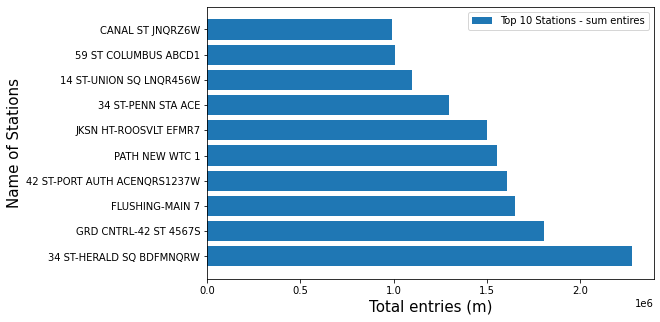

In [93]:
# Create chart for top 10 stations
plt.figure(figsize = [8,5])
x = top_stations.DAILY_ENTRIES
y = top_stations.STATION
plt.xlabel("Total entries (m)", fontsize = 15)
plt.ylabel("Name of Stations", fontsize = 15)
plt.barh(y,x)
plt.legend(['Top 10 Stations - sum entires'], fontsize = 10)

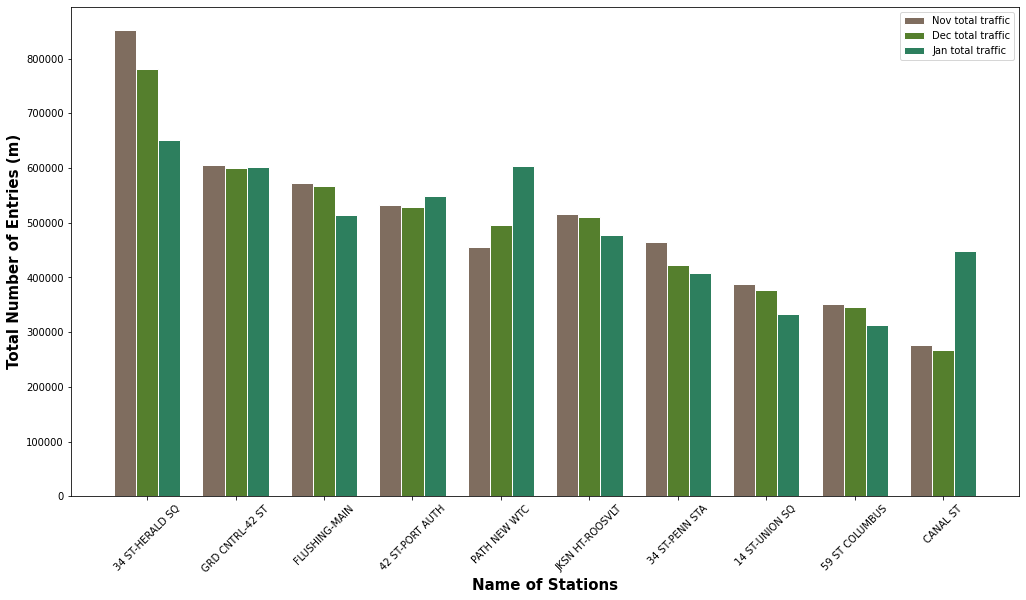

In [94]:
# Create chart for Nov, Dec and Jan for the top 10 stations
plt.figure(figsize = [17,9])
 
barWidth = 0.25
 
bars1 = [851625.0, 604733.0, 572213.0, 532236.0, 455628.0, 515800.0, 464674.0, 387970.0, 351861.0, 277064.0]
bars2 = [781285.0, 600135.0, 567162.0, 528066.0, 495574.0, 511207.0, 422799.0, 377140.0, 345092.0, 266929.0]
bars3 = [650494.0, 602251.0, 513966.0, 548955.0, 603872.0, 477479.0, 408284.0, 332423.0, 313095.0, 447845.0]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Nov total traffic')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Dec total traffic')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Jan total traffic')
 
plt.xlabel('Name of Stations', fontweight='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(bars1))], ['34 ST-HERALD SQ', 'GRD CNTRL-42 ST', 'FLUSHING-MAIN', '42 ST-PORT AUTH', 'PATH NEW WTC','JKSN HT-ROOSVLT', '34 ST-PENN STA','14 ST-UNION SQ','59 ST COLUMBUS','CANAL ST'], rotation=45)
plt.ylabel('Total Number of Entries', fontsize = 15, fontweight='bold')

plt.legend()
plt.show()

In [96]:
# Create masks for the top 5 stations
mask1 = ((turnstiles_df_months_test['MONTH'] == '11') & (turnstiles_df_months_test['STATION'] == "34 ST-HERALD SQ BDFMNQRW"))
mask2 = ((turnstiles_df_months_test['MONTH'] == '11') & (turnstiles_df_months_test['STATION'] == "GRD CNTRL-42 ST 4567S"))
mask3 = ((turnstiles_df_months_test['MONTH'] == '11') & (turnstiles_df_months_test['STATION'] == "FLUSHING-MAIN 7"))
mask4 = ((turnstiles_df_months_test['MONTH'] == '01') & (turnstiles_df_months_test['STATION'] == "42 ST-PORT AUTH ACENQRS1237W"))
mask5 = ((turnstiles_df_months_test['MONTH'] == '01') & (turnstiles_df_months_test['STATION'] == "PATH NEW WTC 1"))

In [101]:
# Check mask 1 for 4 ST-HERALD SQ BDFMNQRW station
turnstiles_df_months_test[mask1].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()

WEEK_idx
0    173620.0
1    180244.0
2    302819.0
3    154641.0
4     40301.0
Name: DAILY_ENTRIES, dtype: float64

In [102]:
# Check mask 2 for RD CNTRL-42 ST 4567S station
turnstiles_df_months_test[mask2].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()

WEEK_idx
0    149508.0
1    154357.0
2    154487.0
3    114532.0
4     31849.0
Name: DAILY_ENTRIES, dtype: float64

In [ ]:
# Check mask 3 for LUSHING-MAIN 7 station
turnstiles_df_months_test[mask3].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()

In [103]:
# Check mask 4 for 42 ST-PORT AUTH ACENQRS1237W station
turnstiles_df_months_test[mask4].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()

WEEK_idx
8      11384.0
9     122460.0
10    122517.0
11    119010.0
12    165408.0
13      8176.0
Name: DAILY_ENTRIES, dtype: float64

In [104]:
# Check mask 5 for PATH NEW WTC 1 station
turnstiles_df_months_test[mask5].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()

WEEK_idx
8       5986.0
9     141539.0
10    187852.0
11    108603.0
12    155675.0
13      4217.0
Name: DAILY_ENTRIES, dtype: float64

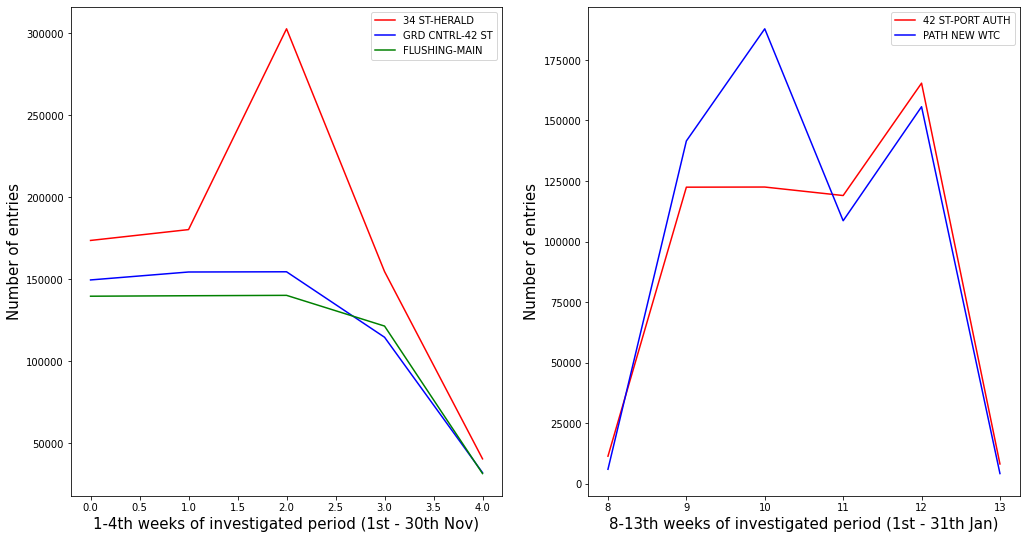

In [105]:
# Chart the 5 selected station’s weekly traffic for the month with the most entries (Nov has 5 weeks and Jan 2020 has 6 weeks)
plt.figure(figsize = [17,9])

plt.subplot(1,2,1)
x = turnstiles_df_months_test[mask1].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()
plt.plot(x, c = 'r')
x2 = turnstiles_df_months_test[mask2].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()
plt.plot(x2, c = 'b')
x3 = turnstiles_df_months_test[mask3].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()
plt.plot(x3, c = 'g')
plt.ylabel("Number of entries", fontsize = 15)
plt.xlabel("1-4th weeks of investigated period (1st - 30th Nov)", fontsize = 15)
plt.legend(['34 ST-HERALD','GRD CNTRL-42 ST','FLUSHING-MAIN'], loc=0)


plt.subplot(1,2,2)
x = turnstiles_df_months_test[mask4].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()
plt.plot(x, c = 'r')
x2 = turnstiles_df_months_test[mask5].groupby(['WEEK_idx']).DAILY_ENTRIES.sum()
plt.plot(x2, c = 'b')
plt.xlabel("8-13th weeks of investigated period (1st - 31th Jan)", fontsize = 15)
plt.ylabel("Number of entries", fontsize = 15)
plt.legend(['42 ST-PORT AUTH','PATH NEW WTC'], loc=0)



In [106]:
# Create DATE_TIME_2 from DATE and use pandas function do_datetime
turnstiles_df_months_test["DATE_TIME_2"] = pd.to_datetime(turnstiles_df_months_test.DATE)

# Create Day_of_week using DATE_TIME_2 with dt (datetime)  function from pandas
turnstiles_df_months_test['Day_of_week'] = turnstiles_df_months_test.DATE_TIME_2.dt.dayofweek

# Create mask 6 for 34 ST-HERALD SQ BDFMNQRW station
mask6 = (turnstiles_df_months_test['STATION'] == "34 ST-HERALD SQ BDFMNQRW")

# Create mask 7 for GRD CNTRL-42 ST 4567S station
mask7 = (turnstiles_df_months_test['STATION'] == "GRD CNTRL-42 ST 4567S")

# Create mask 8 for FLUSHING-MAIN 7 station
mask8 = (turnstiles_df_months_test['STATION'] == "FLUSHING-MAIN 7")

# Create mask 9 for 42 ST-PORT AUTH ACENQRS1237W station
mask9 = (turnstiles_df_months_test['STATION'] == "42 ST-PORT AUTH ACENQRS1237W")

# Craete mask 10 for PATH NEW WTC 1 station
mask10 = (turnstiles_df_months_test['STATION'] == "PATH NEW WTC 1")

In [113]:
# Group by Day_of_week abd get DAILY_ENTRIES mean for each mask
turnstiles_df_months_test_dayofweeks_mean1 = turnstiles_df_months_test[mask6].groupby(["Day_of_week"])[["DAILY_ENTRIES"]].mean()
turnstiles_df_months_test_dayofweeks_mean2 = turnstiles_df_months_test[mask7].groupby(["Day_of_week"])[["DAILY_ENTRIES"]].mean()
turnstiles_df_months_test_dayofweeks_mean3 = turnstiles_df_months_test[mask8].groupby(["Day_of_week"])[["DAILY_ENTRIES"]].mean()
turnstiles_df_months_test_dayofweeks_mean4 = turnstiles_df_months_test[mask9].groupby(["Day_of_week"])[["DAILY_ENTRIES"]].mean()
turnstiles_df_months_test_dayofweeks_mean5 = turnstiles_df_months_test[mask10].groupby(["Day_of_week"])[["DAILY_ENTRIES"]].mean()

In [152]:
for x in range (1, 6):
    print('turnstiles_df_months_test_dayofweeks_mean' + str(x) + ' = turnstiles_df_months_test[mask' + str(x) +'].groupby(["Day_of_week"])[["DAILY_ENTRIES"]].mean()')

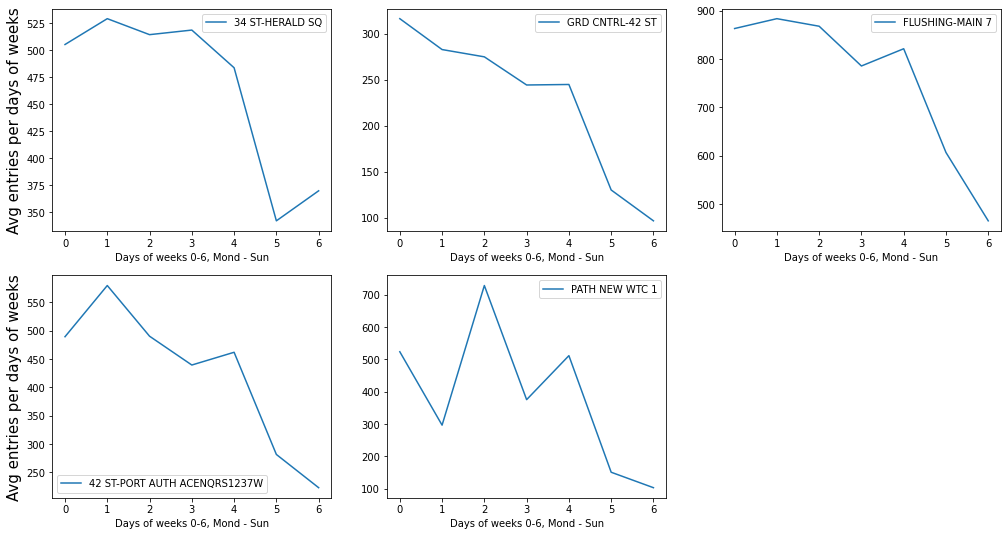

In [124]:
#  Average entries of the station per days of the week (Between Nov 2020 - Jan 2021)
plt.figure(figsize = [17,9])

plt.subplot(2,3,1)
x = turnstiles_df_months_test_dayofweeks_mean1
plt.xlabel("Days of weeks 0-6, Mond - Sun")
plt.ylabel("Avg entries per days of weeks", fontsize = 15)
plt.plot(x)
plt.legend(['34 ST-HERALD SQ'], loc=0)


plt.subplot(2,3,2)
x = turnstiles_df_months_test_dayofweeks_mean2
plt.xlabel("Days of weeks 0-6, Mond - Sun")
plt.plot(x)
plt.legend(['GRD CNTRL-42 ST'], loc=0)


plt.subplot(2,3,3)
x = turnstiles_df_months_test_dayofweeks_mean3
plt.xlabel("Days of weeks 0-6, Mond - Sun")
plt.plot(x)
plt.legend(['FLUSHING-MAIN 7'], loc=0)


plt.subplot(2,3,4)
x = turnstiles_df_months_test_dayofweeks_mean4
plt.xlabel("Days of weeks 0-6, Mond - Sun")
plt.ylabel("Avg entries per days of weeks", fontsize = 15)
plt.plot(x)
plt.legend(['42 ST-PORT AUTH ACENQRS1237W'], loc=0)


plt.subplot(2,3,5)
x = turnstiles_df_months_test_dayofweeks_mean5
plt.xlabel("Days of weeks 0-6, Mond - Sun")
plt.plot(x)
plt.legend(['PATH NEW WTC 1'], loc=0)